## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample
from skimage import io
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())
# from tensorflow.python.client import device_lib

# set the matplotlib backend so figures can be saved in the background
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization, Lambda
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import VGG19
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, accuracy_score

import seaborn as sns


[]
True


## Do some early processing of your metadata for easier model training:

In [34]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
47395,00012045_027.png,Atelectasis,27,12045,44,F,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012045_027.png
46813,00011946_003.png,Effusion,3,11946,39,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00011946_003.png
18495,00004911_014.png,Effusion,14,4911,47,F,PA,2802,2853,0.143,0.143,NaN,/data/images_003/images/00004911_014.png


In [35]:
# As clear from the EDA we have some outlier in the data based on the AGE field, so we should first remove them
all_xray_df = all_xray_df.drop(all_xray_df[all_xray_df['Patient Age'] > 110 ].index)

In [36]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(
        lambda x: x.split('|')).tolist())))

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [37]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
for c_label in all_labels:        
    if len(c_label) > 1:  # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(
            lambda finding, l_label=c_label: 1.0 if l_label in finding else 0)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
111656,00030573_019.png,Effusion|Nodule,19,30573,27,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
56126,00014004_007.png,No Finding,7,14004,55,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
61018,00015056_004.png,Nodule|Pleural_Thickening,4,15056,45,M,PA,2992,2985,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [38]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Finding Labels'].map(lambda x: 'Pneumonia' in x)
all_xray_df['pneumonia_class'] = all_xray_df['pneumonia_class'].astype(str)
# Todo

In [39]:
all_xray_df['Patient Age'] = np.clip(all_xray_df['Patient Age'], 5, 100)
all_xray_df['Patient Male'] = all_xray_df['Patient Gender'].map(lambda x: x.upper()=='M').astype('float32')

In [40]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,Patient Male
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False,1.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0


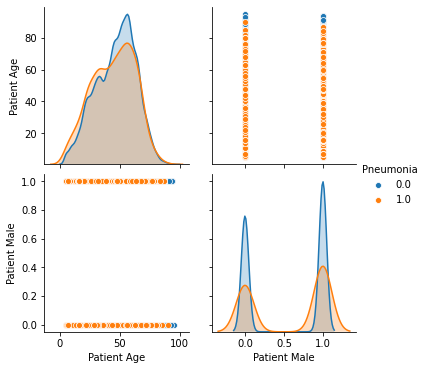

In [41]:
sns.pairplot(all_xray_df[['Patient Age', 'Patient Male', 'Pneumonia']], hue='Pneumonia')

## Create your training and testing data:

In [10]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = train_test_split(vargs, 
                               test_size = 0.2, 
                               stratify = vargs['Pneumonia'])
    
    # Balancing the data in both the set     
    pneu_idx = train_data[train_data.Pneumonia==1].index.tolist()
    npneu_idx = train_data[train_data.Pneumonia==0].index.tolist()
    
    np_sample = sample(npneu_idx,len(pneu_idx))
    train_data = train_data.loc[pneu_idx + np_sample]

    # Generating validation set     
    pneu_idx = val_data[val_data.Pneumonia==1].index.tolist()
    npneu_idx = val_data[val_data.Pneumonia==0].index.tolist()
    
    # we want to make the balance in our validation set more like 20-80 
    np_sample = sample(npneu_idx,4*len(pneu_idx))
    val_data = val_data.loc[pneu_idx + np_sample]
    
    return train_data, val_data

In [11]:
train_data, val_data = create_splits(all_xray_df)

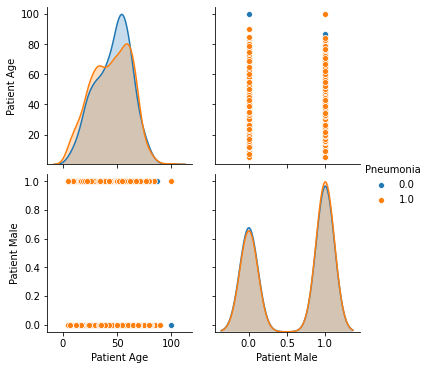

In [12]:
sns.pairplot(train_data[['Patient Age', 'Patient Male', 'Pneumonia']], hue='Pneumonia')

### verify whether data is balance or not

In [13]:
train_data['Pneumonia'].sum()/len(train_data)

0.5

In [14]:
val_data['Pneumonia'].sum()/len(val_data)

0.2

In [15]:
print('train data shape {} \nvalidation data shape {}'.format(train_data.shape, val_data.shape))

train data shape (2290, 30) 
validation data shape (1430, 30)


In [16]:
# of whole data set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(all_xray_df['pneumonia_class']),
                                                 all_xray_df['pneumonia_class'])
print (class_weights)

[ 0.50646406 39.17540182]


In [17]:
counts = train_data.groupby(['pneumonia_class'])['pneumonia_class'].agg(['count'])

In [18]:
counts

,count
pneumonia_class,
False,1145
True,1145


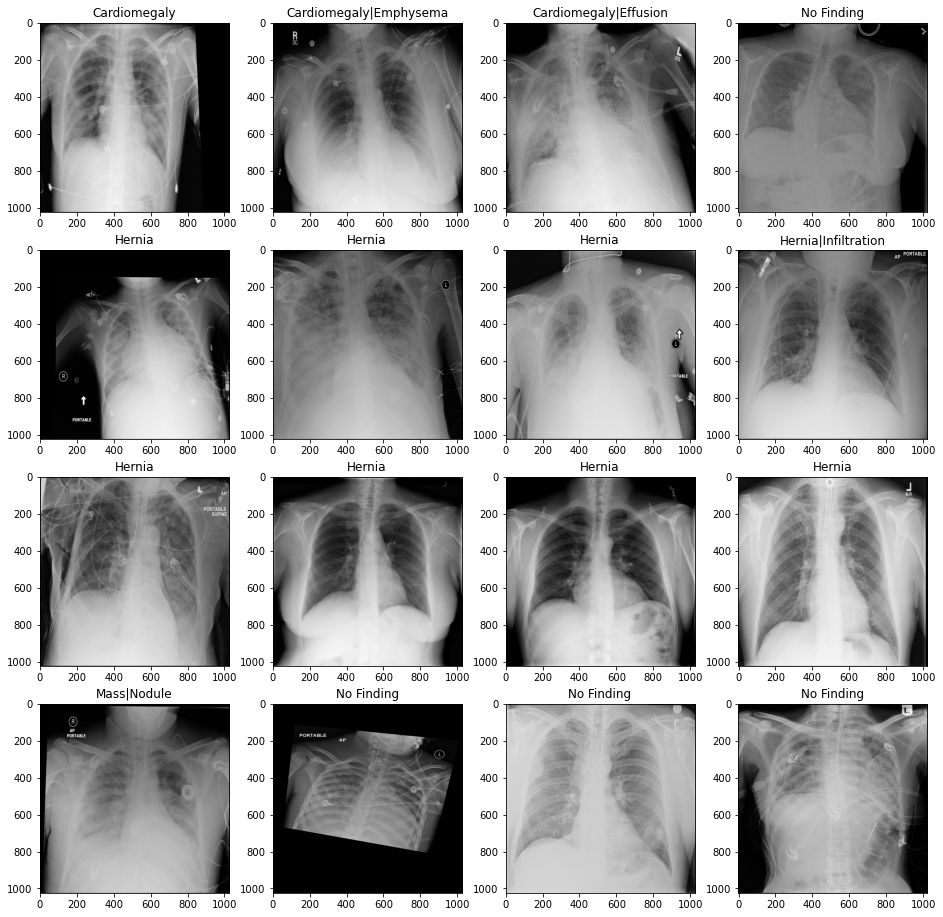

In [19]:
fig, m_axs = plt.subplots(4,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = train_data['Image Index']
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(all_image_paths[img])
    ax.imshow(img,cmap='gray')
    ax.set_title(all_xray_df.iloc[ind]['Finding Labels'])
    ind=ind+1


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

## Define constants 

In [20]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNEL = 3
IMG_SIZE=(IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 100

In [21]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    
    if vargs == 'train':
        my_idg = ImageDataGenerator(rescale=1. / 255.0,
                          horizontal_flip = True, 
                          vertical_flip = False, 
                          height_shift_range= 0.1, 
                          width_shift_range=0.1, 
                          rotation_range=20, 
                          shear_range = 0.1,
                          zoom_range=0.1,
                          fill_mode='nearest')
    else:
        my_idg = ImageDataGenerator(rescale=1. / 255.0)

    return my_idg


def make_train_gen(data_frame, img_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    my_train_idg=my_image_augmentation('train')
    train_gen = my_train_idg.flow_from_dataframe(dataframe=data_frame, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = img_size, 
                                         batch_size = batch_size)
     # Todo

    return train_gen


def make_val_gen(data_frame, img_size, batch_size):
    my_val_idg= my_image_augmentation('validation')

    val_gen = my_val_idg.flow_from_dataframe(dataframe = data_frame, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = img_size, 
                                             batch_size = batch_size) 
    
    # Todo
    return val_gen

In [22]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data, IMG_SIZE, BATCH_SIZE)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [23]:
valY

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [24]:
# get train gen
train_gen = make_train_gen(train_data, IMG_SIZE, BATCH_SIZE)
trainX, trainY = train_gen.next()

Found 2290 validated image filenames belonging to 2 classes.


In [25]:
trainY

array([1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

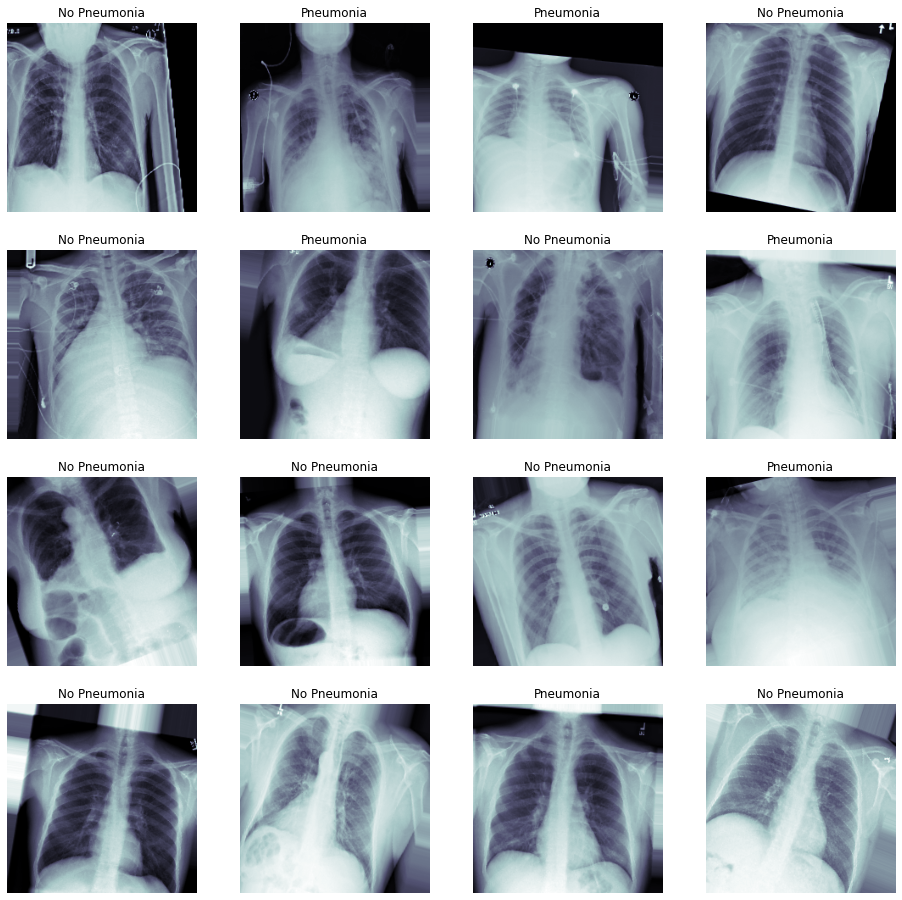

In [26]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [27]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    vgg_model = VGG16(
        weights='imagenet', 
        include_top=True, 
#         input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNEL),
    )

    # Freeze the convolutional base created from the previous step and use that as a feature extractor
    # add a classifier on top of it and train the top-level classifier.
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    transfer_layer = vgg_model.get_layer('block5_pool')
    vgg_model = Model(inputs = vgg_model.input, outputs = transfer_layer.output)
    return vgg_model


In [28]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    pretrained_model = load_pretrained_model()
    pretrained_model.trainable = False

    my_model = Sequential()
    my_model.add(pretrained_model)

#     my_model.add(Dropout(0.5))
#     my_model.add(GlobalAveragePooling2D())
#     my_model.add(Dense(128, activation='relu'))
    
    my_model.add(Flatten())
    my_model.add(BatchNormalization())
#     my_model.add(Flatten())
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.5))
#     my_model.add(Dense(128, activation='relu'))
    my_model.add(Dense(1,activation="sigmoid"))

    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [29]:
my_model =  build_my_model()

553467904/553467096 [==============================] - 7s 0us/step
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
flatten True
fc1 True
fc2 True
predictions True


In [30]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,238,081
Trainable params: 6,473,217
Non-trainable params: 14,764,864
__________________________________

In [30]:
for idx, layer in enumerate(my_model.layers):
    print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))


layer 0: model_1, trainable: False
layer 1: flatten_1, trainable: True
layer 2: batch_normalization_1, trainable: True
layer 3: dense_1, trainable: True
layer 4: dropout_1, trainable: True
layer 5: dense_2, trainable: True


In [31]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=15)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.8, patience=10, 
                                   verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, 
                                   min_lr=0.00001)

callbacks_list = [checkpoint, early]

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [32]:
INITIAL_LEARNING_RATE = 1e-4
optimizer = Adam(learning_rate=INITIAL_LEARNING_RATE)
# optimizer = SGD(lr=INITIAL_LEARNING_RATE, momentum=0.9)
loss = 'binary_crossentropy'
metrics = ['accuracy']

my_model.compile(
    loss=loss,     
    optimizer=optimizer, 
    metrics=metrics
)

### Start training! 

In [33]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(trainY),
                                                 trainY)
print (class_weights)

[0.94339623 1.06382979]


In [34]:
## train your model

# Todo
history = my_model.fit_generator(train_gen,
                                 class_weight = class_weights,
                                 callbacks = callbacks_list,
                                 shuffle = True,
                                 validation_data = (valX, valY), 
                                 verbose = 1,
                                 epochs = 30)

Epoch 1/30
23/23 [==============================] - 66s 3s/step - loss: 0.8258 - accuracy: 0.5769 - val_loss: 0.9261 - val_accuracy: 0.2500

Epoch 00001: loss improved from inf to 0.82565, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
23/23 [==============================] - 60s 3s/step - loss: 0.7755 - accuracy: 0.6179 - val_loss: 0.9543 - val_accuracy: 0.2700

Epoch 00002: loss improved from 0.82565 to 0.77525, saving model to xray_class_my_model.best.hdf5
Epoch 3/30
23/23 [==============================] - 59s 3s/step - loss: 0.7697 - accuracy: 0.6127 - val_loss: 0.7620 - val_accuracy: 0.4700

Epoch 00003: loss improved from 0.77525 to 0.76964, saving model to xray_class_my_model.best.hdf5
Epoch 4/30
23/23 [==============================] - 60s 3s/step - loss: 0.7741 - accuracy: 0.6066 - val_loss: 0.9138 - val_accuracy: 0.2700

Epoch 00004: loss did not improve from 0.76964
Epoch 5/30
23/23 [==============================] - 60s 3s/step - loss: 0.7494 - accuracy: 0.6240 -

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [109]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

100/100 [==============================] - 1s 10ms/step


In [52]:
pred_Y

array([[0.35886484],
       [0.6781298 ],
       [0.04548182],
       [0.9487036 ],
       [0.22881234],
       [0.9791325 ],
       [0.6397738 ],
       [0.3875863 ],
       [0.6310305 ],
       [0.7556903 ],
       [0.29836822],
       [0.7251465 ],
       [0.05458988],
       [0.89013886],
       [0.6620329 ],
       [0.07667477],
       [0.84456456],
       [0.0478067 ],
       [0.04894511],
       [0.63356805],
       [0.14920236],
       [0.858398  ],
       [0.02978968],
       [0.6820528 ],
       [0.41522795],
       [0.24542095],
       [0.25747198],
       [0.21563192],
       [0.15080747],
       [0.3750034 ],
       [0.32180023],
       [0.16022566],
       [0.90438884],
       [0.23779848],
       [0.17007467],
       [0.2716177 ],
       [0.0604785 ],
       [0.720872  ],
       [0.23786163],
       [0.14233094],
       [0.5155116 ],
       [0.5126142 ],
       [0.01945438],
       [0.28095302],
       [0.09828606],
       [0.04829561],
       [0.504458  ],
       [0.068

## Choosing the optimal threshold
Here, we are specially focused on reduction the number of False positive (FP) and False Negatives(FN), **mostly False Negative**, of confusion matrix as the numbers of cases under False Positives would conclude that the patients, who are actually Normal, are facing Pneumonia, whereas False Negatives would conclude that the patients, who actually have Pneumonia, are not classified as suffering from Pneumonia.  
**Since we can tolerate the number of cases of False Positives, but not False Negatives! This may have serious repercussions if not classified correctly. So it is of utmost importance to reduce the number of cases of False Negatives.**  


### Below are some useful metrics and plot which will help us finding the optimal threshold

In [37]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    fig.savefig('auc-plot.png')
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    fig.savefig('pr-plot.png')

# def ...
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    plt.figure(figsize=(12,4))

    xlabel = 'Epoch'    
    legends = ['Training', 'Validation']

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel(xlabel)
    plt.legend(legends, loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(legends, loc='upper left')
    plt.tight_layout()
    plt.savefig('loass-acc.png')
    return

def plot_auc_all(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw = 2, label = 'ROC AUC: {:.2f}'.format(roc_auc))
    plt.plot([0, 1], [0, 1],
             linestyle = '--',
             color = (0.6, 0.6, 0.6),
             label = 'random guessing')
    plt.plot([0, 0, 1], [0, 1, 1],
             linestyle = ':',
             color = 'black', 
             label = 'perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Receiver Operator Characteristic')
    plt.legend(loc = "lower right")
    plt.tight_layout()
    plt.show()

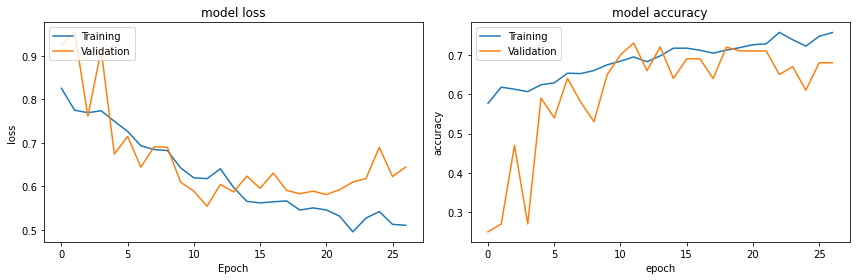

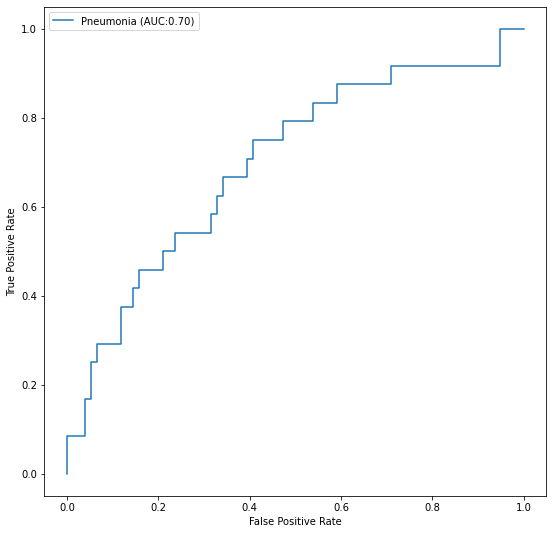

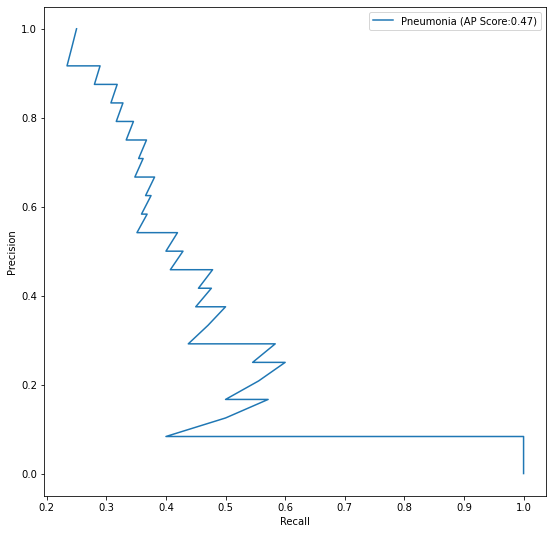

In [38]:
## plot figures

# Todo
plot_history(history)
plot_auc(valY, pred_Y)
plot_pr(valY, pred_Y)


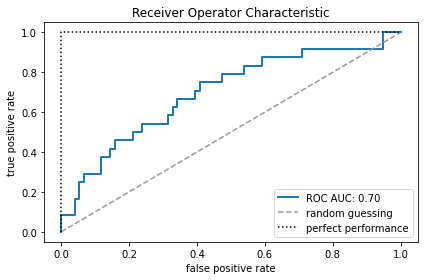

In [39]:
plot_auc_all(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [113]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

print( '\n', '-'*20, 'High precision', '-'*20, '\n')
precision_value = 0.8
idx1 = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx1]))
print('Recall is: '+ str(recall[idx1]))
print('Threshold is: '+ str(thresholds[idx1]))
print('F1 Score is: ' + str(calc_f1(precision[idx1],recall[idx1])))
thresh1 = thresholds[idx1]

print('\n', '-'*20, 'High recall', '-'*20, '\n')
recall_value = 0.8
idx2 = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx2]))
print('Recall is: '+ str(recall[idx2]))
print('Threshold is: '+ str(thresholds[idx2]))
print('F1 Score is: ' + str(calc_f1(precision[idx2],recall[idx2])))
thresh2 = thresholds[idx2]


 -------------------- High precision -------------------- 

Precision is: 0.6666666666666666
Recall is: 0.08333333333333333
Threshold is: 0.90438884
F1 Score is: 0.14814814814814814

 -------------------- High recall -------------------- 

Precision is: 0.31666666666666665
Recall is: 0.7916666666666666
Threshold is: 0.22881234
F1 Score is: 0.45238095238095233


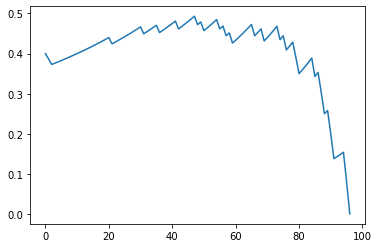

In [46]:
f1_scores = calc_f1(precision, recall)
plt.plot(f1_scores)

In [100]:
# As we want to maximize the Recall, so i have selected the threshold which results in high recall.
threshold = 0.2288

In [101]:
pred_Y = np.where(pred_Y > threshold, 1, 0)

In [102]:
acc = accuracy_score(valY, pred_Y)*100
cm = confusion_matrix(valY, pred_Y, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))


TEST METRICS ----------------------
Accuracy: 26.0%
Precision: 23.404255319148938%
Recall: 91.66666666666666%
F1-score: 37.28813559322034

TRAIN METRIC ----------------------
Train acc: 75.68


In [103]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
print(classification_report(valY, pred_Y, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))# Todo

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.67      0.05      0.10        76
   Normal (Class 1)       0.23      0.92      0.37        24

           accuracy                           0.26       100
          macro avg       0.45      0.48      0.24       100
       weighted avg       0.56      0.26      0.16       100



In [104]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valY, pred_Y)

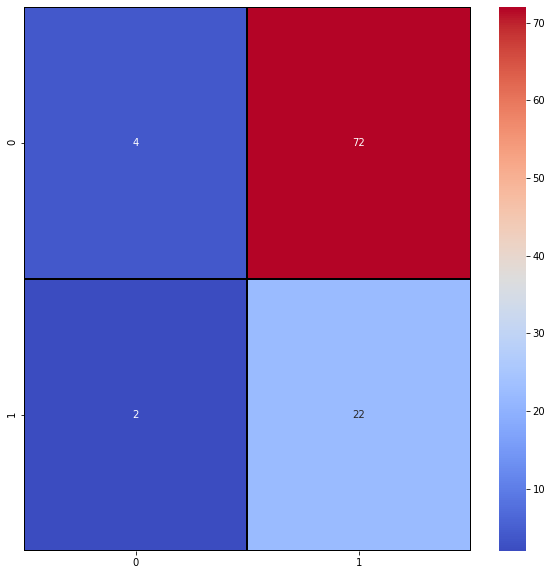

In [105]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "coolwarm", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

## As I said earlier we need to focus more on recall, as cost associated with the classifying Pneumonia pateint as Non-Pneumonia is much higher.
So I have computed the threshold with recall-value = 0.8 (Though it should be 1 ideally but acheiving that is very difficult with this data set). Below is some metric values:  
```
Precision is: 0.31666666666666665  
Recall is: 0.7916666666666666  
Threshold is: 0.22881234  
F1 Score is: 0.45238095238095233  
```


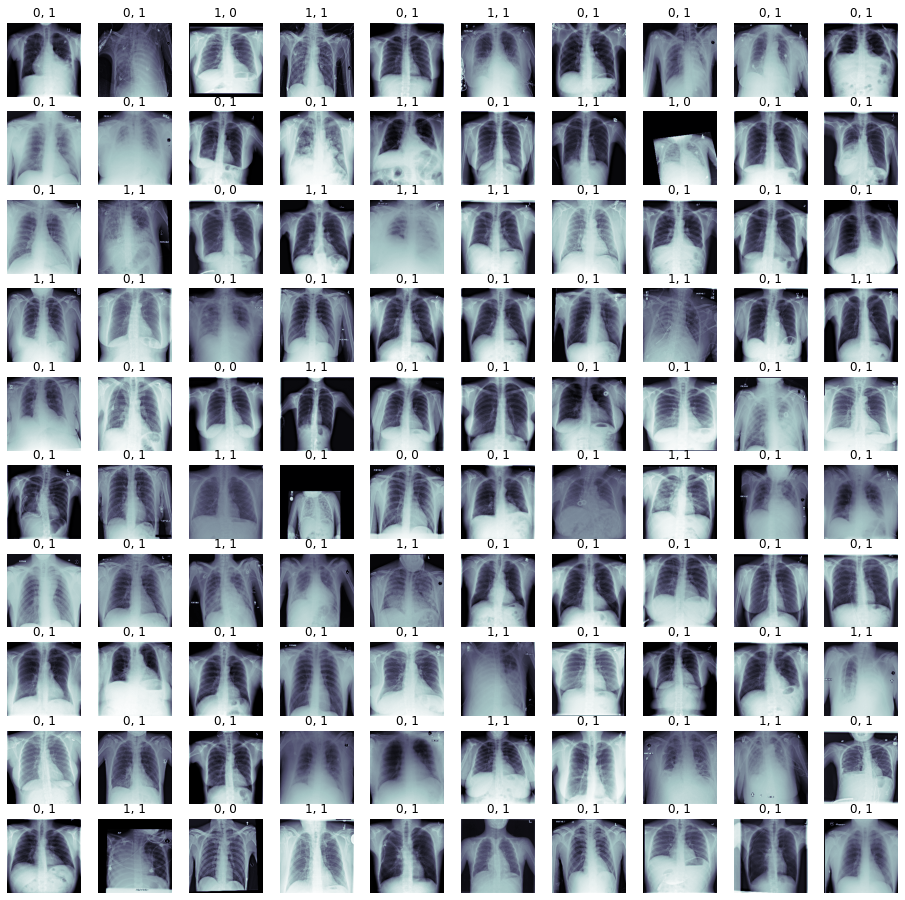

In [106]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo
YOUR_THRESHOLD = 0.288
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [60]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

# Analyse model on sample lables

In [61]:
val_data.size

42900

In [62]:
test_idg = ImageDataGenerator(rescale=1. / 255.0)
test_gen = test_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 1430)

Found 1430 validated image filenames belonging to 2 classes.


In [70]:
testX, testY = test_gen.next()

In [71]:
pred_val_Y = my_model.predict(testX, batch_size = 32, verbose = True)

1430/1430 [==============================] - 13s 9ms/step


In [72]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(testY, pred_val_Y)

precision_value = 0.8
idx1 = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx1]))
print('Recall is: '+ str(recall[idx1]))
print('Threshold is: '+ str(thresholds[idx1]))
print('F1 Score is: ' + str(calc_f1(precision[idx1],recall[idx1])))
thresh1 = thresholds[idx1]

recall_value = 0.8
idx2 = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx2]))
print('Recall is: '+ str(recall[idx2]))
print('Threshold is: '+ str(thresholds[idx2]))
print('F1 Score is: ' + str(calc_f1(precision[idx2],recall[idx2])))
thresh2 = thresholds[idx2]

Precision is: 0.6666666666666666
Recall is: 0.027972027972027972
Threshold is: 0.9793578
F1 Score is: 0.053691275167785234
Precision is: 0.24465811965811965
Recall is: 0.8006993006993007
Threshold is: 0.31891626
F1 Score is: 0.37479541734860883


In [73]:
!ls

 auc-plot.png		        sample_labels.csv
'Build and train model.ipynb'   test1.dcm
 downloader.ipynb	        test2.dcm
 EDA.ipynb		        test3.dcm
 gender-ditr.png	        test4.dcm
 Inference.ipynb	        test5.dcm
 loass-acc.png		        test6.dcm
 my_model.json		        workspace_archive.tar
 pr-plot.png		        xray_class_my_model.best.hdf5


In [74]:
all_sample_df = pd.read_csv('sample_labels.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_sample_df.shape[0])
all_sample_df['path'] = all_sample_df['Image Index'].map(all_image_paths.get)
all_sample_df.sample(3)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4851,00025505_001.png,Mass,1,25505,044Y,M,PA,2892,2991,0.143,0.143,/data/images_011/images/00025505_001.png
4718,00024145_000.png,No Finding,0,24145,042Y,M,PA,2992,2991,0.143,0.143,/data/images_010/images/00024145_000.png
4236,00020837_000.png,No Finding,0,20837,027Y,F,AP,3056,2544,0.139,0.139,/data/images_009/images/00020837_000.png


In [75]:
all_sample_df['pneumonia_class'] = all_sample_df['Finding Labels'].map(lambda x: 'Pneumonia' in x)
all_sample_df['pneumonia_class'] = all_sample_df['pneumonia_class'].astype(str)

In [76]:
all_sample_df.groupby(['pneumonia_class'])['pneumonia_class'].agg(['count'])

,count
pneumonia_class,
False,5544
True,62


In [77]:
sample_gen = test_idg.flow_from_dataframe(dataframe=all_sample_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32)

Found 5606 validated image filenames belonging to 2 classes.


In [78]:
sample_X, sample_Y = next(sample_gen)
pred_sample_Y = my_model.predict(sample_X, batch_size=32, verbose = True)

32/32 [==============================] - 0s 9ms/step


In [79]:
pred_sample_Y[:3]

array([[0.72346413],
       [0.7198891 ],
       [0.79156405]], dtype=float32)

In [80]:
pred_sample_Y[pred_sample_Y > 0.85].size

2